# FEATURE ENGINEERING, FEATURE SELECTION, MODEL BUILDING

In [2]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier 
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE,SelectKBest
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_selection import f_classif, chi2

In [17]:
# Loading the Data
df_test = pd.read_csv('./file/test.csv')
df_train = pd.read_csv('./file/train.csv')

# Feature Engineering

## Numerical Encoding 

In [16]:
df_train = pre_processing(df_train)
df_test = pre_processing(df_test)

## One Hot/Frequency Encoding

In [28]:
train_ap = pd.get_dummies(df_train, columns=['Agency Type','Distribution Channel'], drop_first=True)
train_ap.head(2)

,ID,Agency,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim,Agency Type_Travel Agency,Distribution Channel_Online
0,2010,EPX,Cancellation Plan,61,PHILIPPINES,12.0,0.0,41,0,1,1
1,4245,EPX,Cancellation Plan,4,MALAYSIA,17.0,0.0,35,0,1,1


In [29]:
df_train_ap = freq_encoding(train_ap)
df_train_ap.head(2)

,ID,Duration,Net Sales,Commision (in value),Age,Claim,Agency Type_Travel Agency,Distribution Channel_Online,Destination_fcode,Agency_fcode,Product Name_fcode
0,2010,61,12.0,0.0,41,0,1,1,0.034353,0.501204,0.253374
1,4245,4,17.0,0.0,35,0,1,1,0.083330,0.501204,0.253374


# Feature Selection

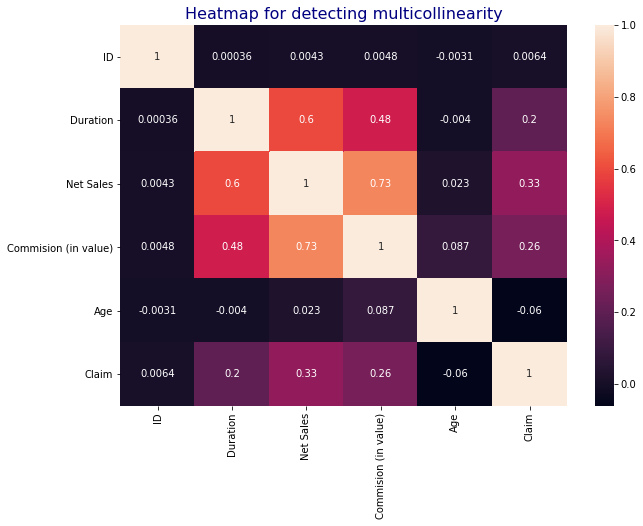

In [30]:
fig = plt.figure(figsize=(10, 7))
sns.heatmap(df_train.corr(), annot=True)
plt.title('Heatmap for detecting multicollinearity', fontsize=16, color='navy')
plt.show()

- Feature are not highly corelated so we can go with ll features

In [49]:
# Independent variable
X_ap = df_train_ap.drop(['Claim','ID'], axis = 1)
X_ap['Total Sale'] = X_ap['Commision (in value)'] + X_ap['Net Sales'] 
# Dependent variable
y_ap = df_train['Claim']

In [50]:
X_ap.head(2)

,Duration,Net Sales,Commision (in value),Age,Agency Type_Travel Agency,Distribution Channel_Online,Destination_fcode,Agency_fcode,Product Name_fcode,Total Sale
0,61,12.0,0.0,41,1,1,0.034353,0.501204,0.253374,12.0
1,4,17.0,0.0,35,1,1,0.083330,0.501204,0.253374,17.0


In [33]:
df_test_ = df_test
df_test_['Total Sale'] = df_test_['Commision (in value)'] + df_test_['Net Sales'] 
df_test_ = pd.get_dummies(df_test_, columns=['Agency Type', 'Distribution Channel'], drop_first=True)

In [34]:
pre_processing(df_test_)
df_test_ = freq_encoding(df_test_)

In [35]:
df_test_.head(2)

,ID,Duration,Net Sales,Commision (in value),Age,Total Sale,Agency Type_Travel Agency,Distribution Channel_Online,Age Group,Destination_fcode,Agency_fcode,Product Name_fcode
0,17631,192,18.0,0.0,36.0,18.0,1,1,Adult,0.034700,0.502208,0.257749
1,15064,2,20.0,0.0,36.0,20.0,1,1,Adult,0.271041,0.502208,0.044824


In [36]:
df_test_ = df_test_.drop('ID', axis=1)

In [68]:
X_train_ap, X_test_ap, y_train_ap, y_test_ap = train_test_split(X_ap, y_ap, random_state = 42, test_size = 0.3)
#scaler = StandardScaler()
scaler  = MinMaxScaler()
X_train_ap = scaler.fit_transform(X_train_ap)
X_test_ap  = scaler.transform(X_test_ap)


## Hyper Parameter Tuning Grid search CV

In [52]:
from sklearn.model_selection import GridSearchCV
def grid_search_cv(estimator, parameters):
    grid_search = GridSearchCV(
        estimator = estimator,
        param_grid = parameters,
        scoring = 'precision',
        n_jobs = 10,
        cv = 10,
        verbose=True
    )
    grid_search.fit(X_ap, y_ap)
    return grid_search

### XGBOOST 

In [53]:
y_train_ap.head(2)

9421     0
39608    0
Name: Claim, dtype: int64

In [54]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler
 
colms = ['Agency Type_Travel Agency', 'Destination_fcode', 'Commision (in value)', 'Product Name_fcode', 'Net Sales', \
 'Distribution Channel_Online', 'Total Sale', 'Agency_fcode', 'Duration', 'Age']


#scaler = StandardScaler()
scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train_ap)
X_test  = scaler.transform(X_test_ap)


xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=180, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

# Fit the model
xgb_model.fit(X_train_ap, y_train_ap)

# Store the predicted values of test data
y_pred_ap = xgb_model.predict(X_test_ap)

xgb_score = accuracy_score(y_test_ap, y_pred_ap)
print("Accuracy Score with XG Boost : ",xgb_score)

xgb_cm = confusion_matrix(y_test_ap, y_pred_ap)
print("Confusion Matrix with XG Boost : \n",xgb_cm)

xgb_cr = classification_report(y_test_ap, y_pred_ap)
print("Classification Report with XG Boost : \n",xgb_cr)

Accuracy Score with XG Boost :  0.9227043904925764
Confusion Matrix with XG Boost : 
 [[25215   930]
 [ 1496  3745]]
Classification Report with XG Boost : 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     26145
           1       0.80      0.71      0.76      5241

    accuracy                           0.92     31386
   macro avg       0.87      0.84      0.85     31386
weighted avg       0.92      0.92      0.92     31386



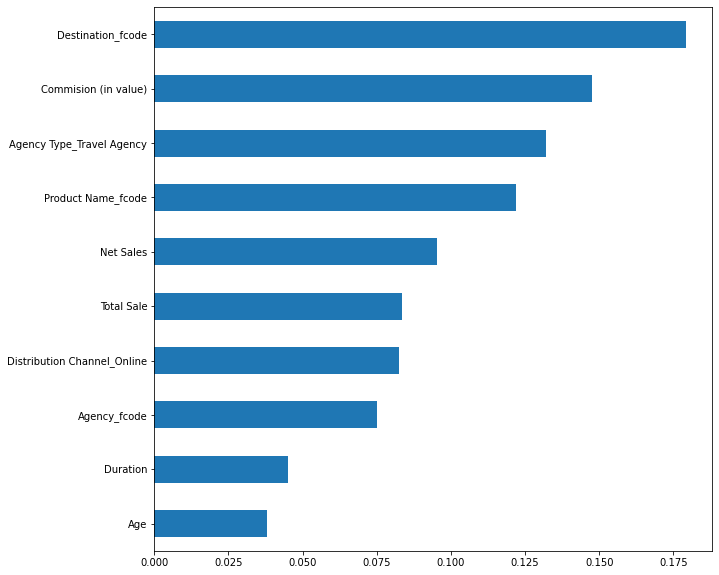

In [55]:
plt.figure(figsize=(10,10))
#plot graph of feature importances for better visualization
feat_importances = pd.Series(xgb_model.feature_importances_, index=X_ap.columns)
feat_importances.sort_values(ascending=True).plot(kind='barh')
plt.show()

In [56]:
feat_importances.sort_values(ascending=False)

Destination_fcode              0.179170
Commision (in value)           0.147430
Agency Type_Travel Agency      0.131994
Product Name_fcode             0.121989
Net Sales                      0.095235
Total Sale                     0.083472
Distribution Channel_Online    0.082546
Agency_fcode                   0.075182
Duration                       0.045107
Age                            0.037875
dtype: float32

### Random Forest

In [59]:
#Random Forest GRID SEARCH CV
estimator = RandomForestClassifier(random_state=9)
parameters = {'n_estimators': [10, 50, 100], 
              'max_features': ['log2', 'sqrt'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2,4,6], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,3,5] 
             }
grid_search = grid_search_cv(estimator, parameters)
print(grid_search.best_estimator_)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   22.6s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  3.3min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  6.2min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed: 10.9min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed: 17.3min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed: 22.4min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed: 31.0min
[Parallel(n_jobs=10)]: Done 3240 out of 3240 | elapsed: 32.0min finished


RandomForestClassifier(max_depth=2, max_features='log2', random_state=9)


In [60]:
# Initialize RandomForrest model to variable rfc
rf = RandomForestClassifier(min_samples_split= 2, min_samples_leaf= 1,\
    max_features= 'sqrt', max_depth= 560,criterion= 'entropy')

# Fit the model
rf.fit(X_train_ap, y_train_ap)

# Store the predicted values of test data
y_pred_rf = rf.predict(X_test_ap)

print("Accuracy Score with XG Boost : ", accuracy_score(y_test_ap, y_pred_rf))
print("Confusion Matrix with XG Boost : \n", classification_report(y_test_ap, y_pred_rf))
print("Classification Report with XG Boost : \n", confusion_matrix(y_test_ap, y_pred_rf))

Accuracy Score with XG Boost :  0.9301918052634933
Confusion Matrix with XG Boost : 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96     26145
           1       0.82      0.74      0.78      5241

    accuracy                           0.93     31386
   macro avg       0.89      0.85      0.87     31386
weighted avg       0.93      0.93      0.93     31386

Classification Report with XG Boost : 
 [[25309   836]
 [ 1355  3886]]


## XG Boost after Grid Serach

In [70]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler
 
colms = ['Agency Type_Travel Agency', 'Dest_fe', 'Commision (in value)', 'Product Name_fe', 'Net Sales', \
 'Distribution Channel_Online', 'Total Sale', 'Agency_fe', 'Duration', 'Age']


#scaler = StandardScaler()
scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train_ap)
X_test  = scaler.transform(X_test_ap)


xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=180, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

# Fit the model
xgb_model.fit(X_train,y_train_ap)

# Store the predicted values of test data
y_pred = xgb_model.predict(X_test)

xgb_score = accuracy_score(y_test_ap,y_pred)
print("Accuracy Score with XG Boost : ",xgb_score)

xgb_cm = confusion_matrix(y_test_ap,y_pred)
print("Confusion Matrix with XG Boost : \n",xgb_cm)

xgb_cr = classification_report(y_test_ap, y_pred)
print("Classification Report with XG Boost : \n",xgb_cr)

Accuracy Score with XG Boost :  0.9339195819792264
Confusion Matrix with XG Boost : 
 [[12668   413]
 [  624  1988]]
Classification Report with XG Boost : 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96     13081
           1       0.83      0.76      0.79      2612

    accuracy                           0.93     15693
   macro avg       0.89      0.86      0.88     15693
weighted avg       0.93      0.93      0.93     15693



## Random Forest After Grid Serach SV

In [86]:
# Initialize RandomForrest model to variable rfc
colms = ['Agency Type_Travel Agency', 'Destination_fcode', 'Commision (in value)', 'Product Name_fcode', 'Net Sales', \
 'Distribution Channel_Online', 'Total Sale', 'Agency_fcode', 'Duration', 'Age']

X_train_ap = X_ap[colms]

X_train_ap, X_test_ap, y_train_ap, y_test_ap = train_test_split(X_ap, y_ap, random_state = 42, test_size = 0.3)
#scaler = StandardScaler()
scaler  = MinMaxScaler()
X_train_ap = scaler.fit_transform(X_train_ap)
X_test_ap  = scaler.transform(X_test_ap)


rf = RandomForestClassifier(min_samples_split= 2, min_samples_leaf= 1,\
    max_features= 'sqrt', max_depth= 560,criterion= 'entropy')
abs
# Fit the model
rf.fit(X_train_ap, y_train_ap)

# Store the predicted values of test data
y_pred_rf = rf.predict(X_test_ap)


print("Accuracy Score with XG Boost : ", accuracy_score(y_test_ap, y_pred_rf))
print("Confusion Matrix with XG Boost : \n", classification_report(y_test_ap, y_pred_rf))
print("Classification Report with XG Boost : \n", confusion_matrix(y_test_ap, y_pred_rf))

Accuracy Score with XG Boost :  0.9514433186771172
Confusion Matrix with XG Boost : 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      4325
           1       0.90      0.81      0.85       906

    accuracy                           0.95      5231
   macro avg       0.93      0.90      0.91      5231
weighted avg       0.95      0.95      0.95      5231

Classification Report with XG Boost : 
 [[4241   84]
 [ 170  736]]


In [74]:
X_ap.head()

,Duration,Net Sales,Commision (in value),Age,Agency Type_Travel Agency,Distribution Channel_Online,Destination_fcode,Agency_fcode,Product Name_fcode,Total Sale
0,61,12.0,0.00,41,1,1,0.034353,0.501204,0.253374,12.00
1,4,17.0,0.00,35,1,1,0.083330,0.501204,0.253374,17.00
2,26,19.8,11.88,47,1,1,0.087211,0.130243,0.130243,31.68
3,15,27.0,0.00,48,1,1,0.033932,0.501204,0.201778,27.00
4,15,37.0,0.00,36,1,1,0.083330,0.501204,0.201778,37.00


# Common Functions

In [ ]:
# Write a function for data preprocessing
def age_convert(age):
    result = ''
    if(age <= 21):
        result = 'Child'
    elif(age <= 50):
        result = 'Adult'
    else:
        result = 'Senior'
    return result


def pre_processing(train_data):
    train_data['Age Group'] = train_data['Age'].map(lambda x: age_convert(x))
    train_data['Duration'][train_data['Duration'] < 0] = train_data['Duration'].median()
    train_data['Duration'][train_data['Duration'] > 540] = 540
    train_data['Age'][train_data['Age'] > 99] = train_data[train_data['Age Group'] == 'Senior']['Age'].mean()
  


In [26]:
def freq_encoding(df):
    # Converting all categorical columns into numeric using frequency encoding, label encoding and one-hot encoding.
    frequency = df.groupby('Destination').size()/len(df)
    df.loc[:,'Destination_fcode'] = df['Destination'].map(frequency)
    frequency_1 = df.groupby('Agency').size()/len(df)
    df.loc[:,'Agency_fcode'] = df['Agency'].map( frequency_1)
    frequency_2 = df.groupby('Product Name').size()/len(df)    
    df.loc[:,'Product Name_fcode'] = df['Product Name'].map(frequency_2)
    df.drop(columns='Agency',axis=1,inplace=True)
    df.drop(columns='Destination',axis=1,inplace=True)
    df.drop(columns='Product Name',axis=1,inplace=True)
    return df